In [13]:
from Bio import SeqIO
import numpy as np
import allel
import matplotlib.pyplot as plt
import pandas as pd

In [39]:
### Read in GFF
f = open('../covid19_population_genomics/reference_genome/reference.gff')
genes = {}
for line in f.readlines():
    if not line.startswith("#"):
        if line.split("\t")[2] == 'CDS':
            gene = line.split(";product=")[1].split(";")[0]
            start = int(line.split("\t")[3])
            stop = int(line.split("\t")[4])
            genes[gene] = {"start": start, "stop": stop}

### Create alignment to GFF index
ref = 'MN908947'
seqs = []

for record in SeqIO.parse('../covid19_population_genomics/interpatient/mar20_filtered.aln', 'fasta'):
    if record.id == ref:
        ref_record = record
    seqs.append(str(record.seq).upper())

align_index = {}
true_pos = 1
align_pos = 1
for pos in ref_record:
    if pos != '-':
        align_index[align_pos] = true_pos
        true_pos += 1
    else:
        align_index[align_pos] = np.nan
    align_pos += 1

In [40]:
## Create scikit-alllel object

P2C = {'A':0, 'C':1, 'T':2, 'G':3}
C2P = {0:'A', 1:'C', 2:'T', 3:'G'}

allele_counts = []
align_pos = 1
for pos in ref_record:
    alleles = [0,0,0,0]
    if not np.isnan(align_index[align_pos]):
        for seq in seqs:
            if seq[align_pos-1] in P2C:
                alleles[P2C[seq[align_pos-1]]] += 1


        allele_counts.append(alleles)
    align_pos += 1
allel1 = allel.AlleleCountsArray(allele_counts)

In [248]:
## calculate pi at every position
nuc_div = []
positions = [x for x in range(1, len(allel1)+1)]
for p in positions:
    nuc_div.append(allel.sequence_diversity(positions, allel1, start=p, stop=p))

In [258]:
f = open('../covid19_population_genomics/interpatient/nucleotide_diversity.txt', 'w+')
i = 1
for pi in nuc_div:
    f.write(str(i) + "\t" + str(pi) + "\n")
    i += 1
f.close()

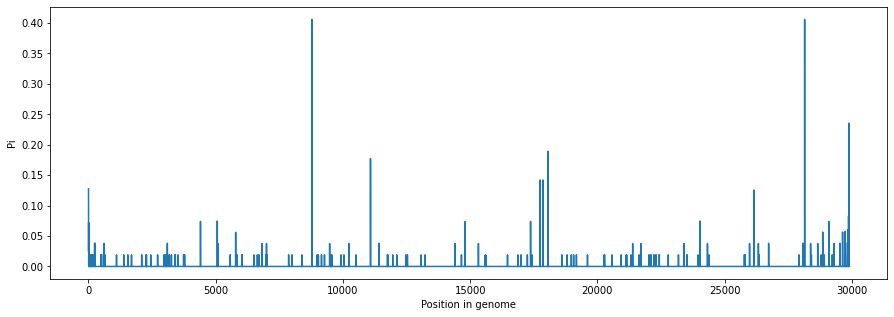

In [255]:
plt.figure(figsize=(15,5))
plt.plot(positions, nuc_div)
# plt.savefig("out.png")
plt.ylabel("Pi")
plt.xlabel("Position in genome")
plt.savefig("interpatient_pi_genome.svg")
plt.show()

In [166]:
## calculate pi for each gene

gene_names = []
genes_pi = []
for g in genes:
    nuc_div = allel.sequence_diversity(positions, allel1, start = genes[g]['start'], stop = genes[g]['stop'])
    gene_names.append(g)
    genes_pi.append(nuc_div)

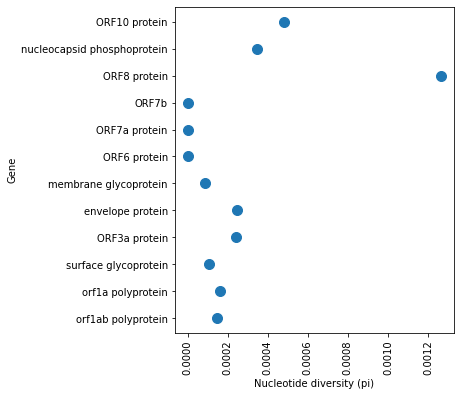

In [256]:
plt.figure(figsize=(5,6))
plt.scatter(genes_pi, gene_names, s=100)
# plt.savefig("out.png")

# plt.stem(gene_names, genes_pi)
plt.ylabel("Gene")
plt.xlabel("Nucleotide diversity (pi)")
plt.xticks(rotation=90)
plt.savefig("gene_pi1.svg")
plt.show()

In [164]:
## calculate pi for each protein product
protein_products = pd.read_table('../covid19_population_genomics/data/reference_genome/COVID_genes_table_v3.tsv', sep="\t")
gene_names = []
genes_pi = []

for index, p in protein_products.iterrows():
    nuc_div = allel.sequence_diversity(positions, allel1, start = p['start'], stop = p['stop'])
    gene_names.append(p['name'])
    genes_pi.append(nuc_div)

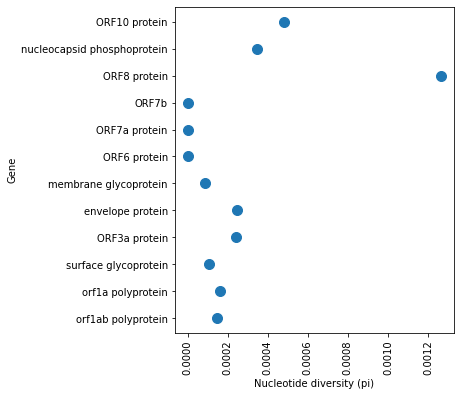

In [257]:
plt.figure(figsize=(5,6))
plt.scatter(genes_pi, gene_names, s=100)
# plt.savefig("out.png")

# plt.stem(gene_names, genes_pi)
plt.ylabel("Gene")
plt.xlabel("Nucleotide diversity (pi)")
plt.xticks(rotation=90)
plt.savefig("gene_pi2.svg")
plt.show()
